# Feature Engineering

The previous sections outline the fundamental ideas of machine learning, but all of the examples assume that you have numerical data in a tidy, ``[n_samples, n_features]`` format.
In the real world, data rarely comes in such a form.
With this in mind, one of the more important steps in using machine learning in practice is *feature engineering*: that is, taking whatever information you have about your problem and turning it into numbers that you can use to build your feature matrix.

In this section, we will cover a few common examples of feature engineering tasks: features for representing *categorical data*, features for representing *text*, and features for representing *images*.
Additionally, we will discuss *derived features* for increasing model complexity and *imputation* of missing data.
Often this process is known as *vectorization*, as it involves converting arbitrary data into well-behaved vectors.

## Categorical Features

One common type of non-numerical data is *categorical* data.
For example, imagine you are exploring some data on housing prices, and along with numerical features like "price" and "rooms", you also have "neighborhood" information.
For example, your data might look something like this:

In [1]:
data = [
    {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
    {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
    {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
]

You might be tempted to encode this data with a straightforward numerical mapping:

In [2]:
{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3};

It turns out that this is not generally a useful approach in Scikit-Learn: the package's models make the fundamental assumption that numerical features reflect algebraic quantities.
Thus such a mapping would imply, for example, that *Queen Anne < Fremont < Wallingford*, or even that *Wallingford - Queen Anne = Fremont*, which (niche demographic jokes aside) does not make much sense.

In this case, one proven technique is to use *one-hot encoding*, which effectively creates extra columns indicating the presence or absence of a category with a value of 1 or 0, respectively.
When your data comes as a list of dictionaries, Scikit-Learn's ``DictVectorizer`` will do this for you:

In [3]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]], dtype=int32)

Notice that the 'neighborhood' column has been expanded into three separate columns, representing the three neighborhood labels, and that each row has a 1 in the column associated with its neighborhood.
With these categorical features thus encoded, you can proceed as normal with fitting a Scikit-Learn model.

To see the meaning of each column, you can inspect the feature names:

In [4]:
vec.get_feature_names()

['neighborhood=Fremont',
 'neighborhood=Queen Anne',
 'neighborhood=Wallingford',
 'price',
 'rooms']

There is one clear disadvantage of this approach: if your category has many possible values, this can *greatly* increase the size of your dataset.
However, because the encoded data contains mostly zeros, a sparse output can be a very efficient solution:

In [5]:
vec = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)

<4x5 sparse matrix of type '<class 'numpy.int32'>'
	with 12 stored elements in Compressed Sparse Row format>

In [6]:
vec.feature_names_

['neighborhood=Fremont',
 'neighborhood=Queen Anne',
 'neighborhood=Wallingford',
 'price',
 'rooms']

## sklearn.preprocessing: OneHotEncoder

Encode categorical integer features using a one-hot aka one-of-K scheme.

In [10]:
from sklearn import preprocessing
import pandas as pd

titanic = {'name': ['Owen Harris Braund','John Bradley Cuming','Laina Heikkinen'],
           'gender':['male', 'male', 'female'],
           'ticket':['A/5 21171','PC 17599','STON/O2. 3101282'],
           'cabin':['','C85',''],
           'embarked':['S','C','S']}

df = pd.DataFrame(titanic)
enc = preprocessing.LabelEncoder()

df['name']=enc.fit_transform(df['name'])
df

,name,gender,ticket,cabin,embarked
0,2,male,A/5 21171,,S
1,0,male,PC 17599,C85,C
2,1,female,STON/O2. 3101282,,S


In [12]:
from sklearn import preprocessing
import pandas as pd
from collections import defaultdict

d = defaultdict(preprocessing.LabelEncoder)

titanic = {'name': ['Owen Harris Braund','John Bradley Cuming','Laina Heikkinen'],
           'gender':['male', 'male', 'female'],
           'ticket':['A/5 21171','PC 17599','STON/O2. 3101282'],
           'cabin':['','C85',''],
           'embarked':['S','C','S']}

df = pd.DataFrame(titanic)

# Encoding the variable
fit = df.apply(lambda x: d[x.name].fit_transform(x))
fit

,name,gender,ticket,cabin,embarked
0,2,1,0,0,1
1,0,1,1,1,0
2,1,0,2,0,1


In [16]:
# Inverse the encoded
df_new=fit.apply(lambda x: d[x.name].inverse_transform(x))
df_new

,name,gender,ticket,cabin,embarked
0,Owen Harris Braund,male,A/5 21171,,S
1,John Bradley Cuming,male,PC 17599,C85,C
2,Laina Heikkinen,female,STON/O2. 3101282,,S


## Pandas

Pandas has ``get_dummies()`` function that able to convert categorical variables to dummy variables

In [17]:
import pandas as pd
import numpy as np
my_data = np.array([[5, 'a', 1],
                    [3, 'b', 3],
                    [1, 'b', 2],
                    [3, 'a', 1],
                    [4, 'b', 2],
                    [7, 'c', 1],
                    [7, 'c', 1]])                
df = pd.DataFrame(data=my_data, columns=['y', 'dummy', 'x'])
just_dummy = pd.get_dummies(df['dummy'])
df_1 = pd.concat([df, just_dummy], axis=1)      
df_1.drop(['dummy', 'c'], inplace=True, axis=1)
df_1

,y,x,a,b
0,5,1,1,0
1,3,3,0,1
2,1,2,0,1
3,3,1,1,0
4,4,2,0,1
5,7,1,0,0
6,7,1,0,0


### Exercise 1

Encode the gender using the one-hot encoding technique.

```{python}
raw_data = {'first_name': ['Jason', 'Tina', 'Rish', 'Wesley ', 'Amy'],
        'last_name': ['Phoon', 'Lau', 'Richer', 'Lee', 'Lim'],
        'gender': ['male', 'female', 'male', 'male', 'female']}
```

In [18]:
from sklearn import preprocessing
import pandas as pd

raw_data = {'first_name': ['Jason', 'Tina', 'Rish', 'Wesley ', 'Amy'],
        'last_name': ['Phoon', 'Lau', 'Richer', 'Lee', 'Lim'],
        'gender': ['male', 'female', 'male', 'male', 'female']}

df = pd.DataFrame(raw_data)
enc = preprocessing.LabelEncoder()
print(df)
enc.fit_transform(df['gender'])

  first_name last_name  gender
0      Jason     Phoon    male
1       Tina       Lau  female
2       Rish    Richer    male
3    Wesley        Lee    male
4        Amy       Lim  female


array([1, 0, 1, 1, 0])

Many (though not yet all) of the Scikit-Learn estimators accept such sparse inputs when fitting and evaluating models. ``sklearn.preprocessing.OneHotEncoder`` and ``sklearn.feature_extraction.FeatureHasher`` are two additional tools that Scikit-Learn includes to support this type of encoding.

### LabelEncoder

Encode labels with value between 0 and n_classes-1. LabelEncoder assigns ordinal levels to categorical data. 

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train = ["Selangor", "Selangor", "Wilayah Persekutuan", "Kedah"]
test = ["Wilayah Persekutuan", "Wilayah Persekutuan", "Selangor"]

le.fit(train)

#print the encoded label
print(le.classes_)

#print the label for Test
le.transform(test)


['Kedah' 'Selangor' 'Wilayah Persekutuan']


array([2, 2, 1], dtype=int64)

In [12]:
#print back the actual data values
le.inverse_transform([1,1,0,2])

C:\Users\A1825\AppData\Local\Continuum\anaconda3\envs\ubaru\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['Selangor', 'Selangor', 'Kedah', 'Wilayah Persekutuan'],
      dtype='<U19')

### Exercise 2

Load the iris dataset and use the ``LabelEncoder`` to encode the 'Species' target variabe

In [20]:
from sklearn.datasets import load_iris

iris = load_iris()

print(iris.target_names)

enc = preprocessing.LabelEncoder()

enc.fit_transform(iris.target_names)

['setosa' 'versicolor' 'virginica']


array([0, 1, 2], dtype=int64)

## Text Features

Another common need in feature engineering is to convert text to a set of representative numerical values.
For example, most automatic mining of social media data relies on some form of encoding the text as numbers.
One of the simplest methods of encoding data is by *word counts*: you take each snippet of text, count the occurrences of each word within it, and put the results in a table.

For example, consider the following set of three phrases:

In [21]:
sample = ['problem of evil',
          'evil queen',
          'horizon problem']

For a vectorization of this data based on word count, we could construct a column representing the word "problem," the word "evil," the word "horizon," and so on.
While doing this by hand would be possible, the tedium can be avoided by using Scikit-Learn's ``CountVectorizer``:

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(sample)

The result is a sparse matrix recording the number of times each word appears; it is easier to inspect if we convert this to a ``DataFrame`` with labeled columns:

In [23]:
import pandas as pd
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,1,0,1,1,0
1,1,0,0,0,1
2,0,1,0,1,0


There are some issues with this approach, however: the raw word counts lead to features which put too much weight on words that appear very frequently, and this can be sub-optimal in some classification algorithms.
One approach to fix this is known as *term frequency-inverse document frequency* (*TF–IDF*) which weights the word counts by a measure of how often they appear in the documents.
The syntax for computing these features is similar to the previous example:

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(sample)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,0.517856,0.000000,0.680919,0.517856,0.000000
1,0.605349,0.000000,0.000000,0.000000,0.795961
2,0.000000,0.795961,0.000000,0.605349,0.000000


## Image Features

Another common need is to suitably encode *images* for machine learning analysis.
The simplest approach is what we used for the handwritten digits recognition by simply using the pixel values themselves.

But depending on the application, such approaches may not be optimal.

A comprehensive summary of feature extraction techniques for images is well beyond the scope of this section, but you can find excellent implementations of many of the standard approaches in the [Scikit-Image project](http://scikit-image.org).

## Derived Features

Another useful type of feature is one that is mathematically derived from some input features.
We saw an example of this in **Hyperparameters and Model Validation** when we constructed *polynomial features* from our input data.

We saw that we could convert a linear regression into a polynomial regression not by changing the model, but by transforming the input!
This is sometimes known as *basis function regression*.

For example, this data clearly cannot be well described by a straight line:

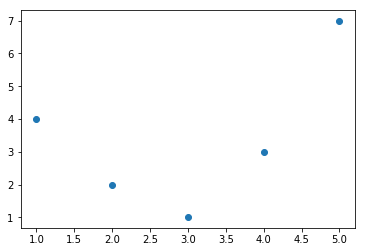

In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])
plt.scatter(x, y);

Still, we can fit a line to the data using ``LinearRegression`` and get the optimal result:

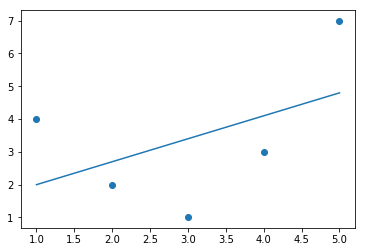

In [26]:
from sklearn.linear_model import LinearRegression
X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit);

It's clear that we need a more sophisticated model to describe the relationship between $x$ and $y$.

One approach to this is to transform the data, adding extra columns of features to drive more flexibility in the model.
For example, we can add polynomial features to the data this way:

In [27]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
print(X2)

[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]]


The derived feature matrix has one column representing $x$, and a second column representing $x^2$, and a third column representing $x^3$.
Computing a linear regression on this expanded input gives a much closer fit to our data:

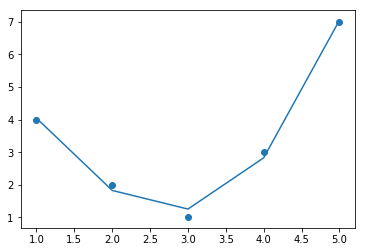

In [28]:
model = LinearRegression().fit(X2, y)
yfit = model.predict(X2)
plt.scatter(x, y)
plt.plot(x, yfit);

This idea of improving a model not by changing the model, but by transforming the inputs, is fundamental to many of the more powerful machine learning methods.

## Imputation of Missing Data

Another common need in feature engineering is handling of missing data.
We discussed the handling of missing data in ``DataFrame``s and saw that often the ``NaN`` value is used to mark missing values.

For example, we might have a dataset that looks like this:

In [29]:
from numpy import nan
X = np.array([[ nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   5,   2  ],
              [ 4,   nan, 6  ],
              [ 8,   8,   1  ]])
y = np.array([14, 16, -1,  8, -5])

When applying a typical machine learning model to such data, we will need to first replace such missing data with some appropriate fill value.
This is known as *imputation* of missing values, and strategies range from simple (e.g., replacing missing values with the mean of the column) to sophisticated (e.g., using matrix completion or a robust model to handle such data).

The sophisticated approaches tend to be very application-specific, and we won't dive into them here.
For a baseline imputation approach, using the mean, median, or most frequent value, Scikit-Learn provides the ``Imputer`` class:

In [32]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
X2 = imp.fit_transform(X)
X2

array([[4.5, 0. , 3. ],
       [3. , 7. , 9. ],
       [3. , 5. , 2. ],
       [4. , 5. , 6. ],
       [8. , 8. , 1. ]])

In [33]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='most_frequent')
X2 = imp.fit_transform(X)
X2

array([[3., 0., 3.],
       [3., 7., 9.],
       [3., 5., 2.],
       [4., 0., 6.],
       [8., 8., 1.]])

We see that in the resulting data, the two missing values have been replaced with the mean of the remaining values in the column. This imputed data can then be fed directly into, for example, a ``LinearRegression`` estimator:

In [34]:
model = LinearRegression().fit(X2, y)
model.predict(X2)

array([ 8.21123945, 14.1271657 ,  3.06186139, 12.49966681, -5.89993336])

## Pandas: fillna

Fill NA/NaN values using the specified method. For more information, read the [documentation](http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.DataFrame.fillna.html)

In [35]:
import pandas as pd

raw_data = {'first_name': ['Jason', np.nan, 'Tina', 'Jake', 'Amy'],
        'last_name': ['Miller', np.nan, 'Ali', 'Milner', 'Cooze'],
        'age': [42, np.nan, 36, 24, 73],
        'sex': ['m', np.nan, 'f', 'm', 'f'],
        'preTestScore': [4, np.nan, np.nan, 2, 3],
        'postTestScore': [25, np.nan, np.nan, 62, 70]}
df = pd.DataFrame(raw_data, columns = ['first_name', 'last_name', 'age', 'sex', 'preTestScore', 'postTestScore'])
df

#Fill in missing data with zeros
# df.fillna(0)

#Fill in missing data with bfill/ffill
# df.fillna(method='bfill')

,first_name,last_name,age,sex,preTestScore,postTestScore
0,Jason,Miller,42.0,m,4.0,25.0
1,NaN,NaN,NaN,NaN,NaN,NaN
2,Tina,Ali,36.0,f,NaN,NaN
3,Jake,Milner,24.0,m,2.0,62.0
4,Amy,Cooze,73.0,f,3.0,70.0


In [36]:
# Fill in missing in preTestScore with the mean value of preTestScore
df["preTestScore"].fillna(df["preTestScore"].mean(), inplace=True)
df

,first_name,last_name,age,sex,preTestScore,postTestScore
0,Jason,Miller,42.0,m,4.0,25.0
1,NaN,NaN,NaN,NaN,3.0,NaN
2,Tina,Ali,36.0,f,3.0,NaN
3,Jake,Milner,24.0,m,2.0,62.0
4,Amy,Cooze,73.0,f,3.0,70.0


In [37]:
df["postTestScore"].fillna(df["postTestScore"].median(), inplace=True)
df

,first_name,last_name,age,sex,preTestScore,postTestScore
0,Jason,Miller,42.0,m,4.0,25.0
1,NaN,NaN,NaN,NaN,3.0,62.0
2,Tina,Ali,36.0,f,3.0,62.0
3,Jake,Milner,24.0,m,2.0,62.0
4,Amy,Cooze,73.0,f,3.0,70.0


In [38]:
df["age"].fillna(method='ffill', inplace=True)
df

,first_name,last_name,age,sex,preTestScore,postTestScore
0,Jason,Miller,42.0,m,4.0,25.0
1,NaN,NaN,42.0,NaN,3.0,62.0
2,Tina,Ali,36.0,f,3.0,62.0
3,Jake,Milner,24.0,m,2.0,62.0
4,Amy,Cooze,73.0,f,3.0,70.0


In [30]:
df["sex"].fillna(method='bfill', inplace=True)
df

,first_name,last_name,age,sex,preTestScore,postTestScore
0,Jason,Miller,42.0,m,4.0,25.0
1,NaN,NaN,42.0,f,3.0,62.0
2,Tina,Ali,36.0,f,3.0,62.0
3,Jake,Milner,24.0,m,2.0,62.0
4,Amy,Cooze,73.0,f,3.0,70.0


### Exercise 3

Read the [Heart Disease Data Set](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) for 'processed.cleveland.data' and impute the missing values.

In [46]:
import pandas as pd

heart = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data', header=None, na_values='?')
heart.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num',]

In [47]:
heart.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [49]:
heart.isnull().values.sum()

6

In [50]:
heart[heart.isnull().any(axis=1)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,NaN,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,NaN,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,NaN,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,NaN,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,NaN,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,NaN,3.0,0


In [51]:
#impute the missing values
heart["ca"].fillna(heart["ca"].mean(), inplace=True)
heart["thal"].fillna(heart["thal"].mean(), inplace=True)

In [52]:
nans = lambda heart: heart[heart.isnull().any(axis=1)]
nans(heart)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num


In [53]:
heart.iloc[[87, 166, 192, 266, 287,302]]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.000000,4.734219,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,0.672241,3.000000,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,0.672241,7.000000,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.000000,4.734219,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,0.672241,7.000000,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,0.672241,3.000000,0


## Feature Pipelines

With any of the preceding examples, it can quickly become tedious to do the transformations by hand, especially if you wish to string together multiple steps.
For example, we might want a processing pipeline that looks something like this:

1. Impute missing values using the mean
2. Transform features to quadratic
3. Fit a linear regression

To streamline this type of processing pipeline, Scikit-Learn provides a ``Pipeline`` object, which can be used as follows:

In [55]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

model = make_pipeline(SimpleImputer(strategy='mean'),
                      PolynomialFeatures(degree=2),
                      LinearRegression())

In [56]:
X = np.array([[ nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   5,   2  ],
              [ 4,   nan, 6  ],
              [ 8,   8,   1  ]])
y = np.array([14, 16, -1,  8, -5])

This pipeline looks and acts like a standard Scikit-Learn object, and will apply all the specified steps to any input data.

In [57]:
model.fit(X, y)  # X with missing values, from above
print(model.predict(X))

[14. 16. -1.  8. -5.]


All the steps of the model are applied automatically.
Notice that for the simplicity of this demonstration, we've applied the model to the data it was trained on; this is why it was able to perfectly predict the result. However, in most time, we need to fine tune the hyperparameters and perform model validation.

### Exercise 4

Given the following code, use ``pipeline`` to transform to ``PolynomialFeatures`` with degree=2 and fit the ``LinearRegression`` model.

```{python}
import numpy as np
from sklearn.linear_model import LinearRegression

x = np.arange(10)[:, None]
y = np.ravel(x) ** 2

p = np.array([1, 2])
model = LinearRegression().fit(x ** p, y)
model.predict(11 ** p)
```

In [58]:
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

x = np.arange(10)[:, None]
y = np.ravel(x) ** 2 #flatten up the array

# p = np.array([1, 2])
# model = LinearRegression().fit(x ** p, y)
# model.predict(11 ** p)

pipemodel = make_pipeline(PolynomialFeatures(degree=2),LinearRegression())

pipemodel.fit(x, y)
print(y)
print(pipemodel.predict(x))

[ 0  1  4  9 16 25 36 49 64 81]
[3.55271368e-15 1.00000000e+00 4.00000000e+00 9.00000000e+00
 1.60000000e+01 2.50000000e+01 3.60000000e+01 4.90000000e+01
 6.40000000e+01 8.10000000e+01]


In [59]:
import numpy as np
from sklearn.linear_model import LinearRegression

x = np.arange(10)[:, None]
y = np.ravel(x) ** 2

p = np.array([1, 2])
model = LinearRegression().fit(x ** p, y)
model.predict(x ** p)
print(y)
print(model.predict(x ** p))

[ 0  1  4  9 16 25 36 49 64 81]
[1.0658141e-14 1.0000000e+00 4.0000000e+00 9.0000000e+00 1.6000000e+01
 2.5000000e+01 3.6000000e+01 4.9000000e+01 6.4000000e+01 8.1000000e+01]


## Feature Scaling and Normalization

An alternative approach to Z-score normalization (or standardization) is the so-called Min-Max scaling (often also simply called “normalization” - a common cause for ambiguities).
In this approach, the data is scaled to a fixed range - usually 0 to 1.
The cost of having this bounded range - in contrast to standardization - is that we will end up with smaller standard deviations, which can suppress the effect of outliers.

A Min-Max scaling is typically done via the following equation:

$$X_{norm}=\frac{X-X_{min}}{X_{max} - X_{min}} $$

In [60]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/wine_data.csv',header=None,usecols=[0,1,2])
df.columns=['Class label', 'Alcohol', 'Malic acid']
df.head()

,Class label,Alcohol,Malic acid
0,1,14.23,1.71
1,1,13.20,1.78
2,1,13.16,2.36
3,1,14.37,1.95
4,1,13.24,2.59


In [61]:
from sklearn import preprocessing

#standard scale transform
std_scale = preprocessing.StandardScaler().fit(df[['Alcohol', 'Malic acid']])
df_std = std_scale.transform(df[['Alcohol', 'Malic acid']])

#min max scale transform
minmax_scale = preprocessing.MinMaxScaler().fit(df[['Alcohol', 'Malic acid']])
df_minmax = minmax_scale.transform(df[['Alcohol', 'Malic acid']])

print('Mean after standardization:\nAlcohol={:.2f}, Malic acid={:.2f}'
      .format(df_std[:,0].mean(), df_std[:,1].mean()))
print('\nStandard deviation after standardization:\nAlcohol={:.2f}, Malic acid={:.2f}'
      .format(df_std[:,0].std(), df_std[:,1].std()))

Mean after standardization:
Alcohol=-0.00, Malic acid=-0.00

Standard deviation after standardization:
Alcohol=1.00, Malic acid=1.00


Plot to show the standardized and normalized data points

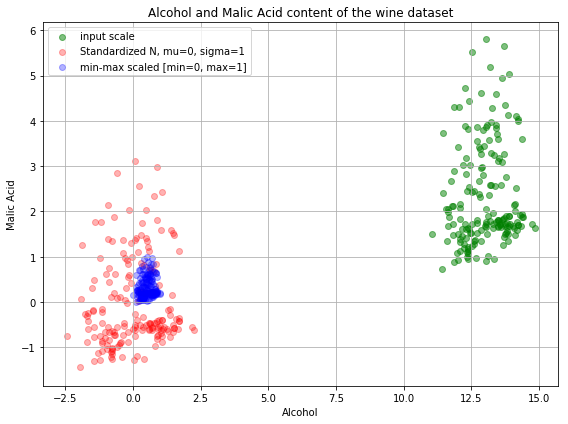

In [62]:
%matplotlib inline
from matplotlib import pyplot as plt

def plot():
    plt.figure(figsize=(8,6))

    plt.scatter(df['Alcohol'], df['Malic acid'],color='green', label='input scale', alpha=0.5)
    plt.scatter(df_std[:,0], df_std[:,1], color='red', label='Standardized N, mu=0, sigma=1', alpha=0.3)
    plt.scatter(df_minmax[:,0], df_minmax[:,1],color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

    plt.title('Alcohol and Malic Acid content of the wine dataset')
    plt.xlabel('Alcohol')
    plt.ylabel('Malic Acid')
    plt.legend(loc='upper left')
    plt.grid()

    plt.tight_layout()

plot()
plt.show();

### Exercise 5

Use the ``MinMaxScaler`` to normalized the following dataframe

In [63]:
import pandas as pd

s1 = pd.Series([1, 2, 3, 4, 5, 6], index=(range(6)))
s2 = pd.Series([10, 9, 8, 7, 6, 5], index=(range(6)))
df = pd.DataFrame(dict(s1=s1,s2=s2), columns=['s1','s2'])
df.head()

,s1,s2
0,1,10
1,2,9
2,3,8
3,4,7
4,5,6


C:\Users\aswad\AppData\Local\Continuum\anaconda3\envs\astafa\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


[[0.  1. ]
 [0.2 0.8]
 [0.4 0.6]
 [0.6 0.4]
 [0.8 0.2]
 [1.  0. ]]


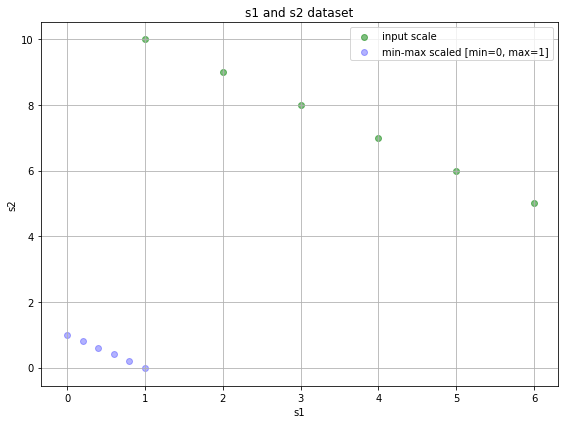

In [64]:
from sklearn.preprocessing import MinMaxScaler

#min max scale transform
minmax_scale = MinMaxScaler().fit(df[['s1','s2']])
df_minmax = minmax_scale.transform(df[['s1', 's2']])

print(df_minmax)

def plot():
    plt.figure(figsize=(8,6))

    plt.scatter(df['s1'], df['s2'],color='green', label='input scale', alpha=0.5)
    plt.scatter(df_minmax[:,0], df_minmax[:,1],color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

    plt.title('s1 and s2 dataset')
    plt.xlabel('s1')
    plt.ylabel('s2')
    plt.legend(loc='upper right')
    plt.grid()

    plt.tight_layout()

plot()
plt.show();